In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [30]:
# Directories
data_dir = './data_kk'
categories = ['kk_blur', 'kk_noise', 'kk_normal']

# Preprocessing function (using balanced dataset as per the smallest class)
def preprocess_images(data_dir, categories, target_size=(128, 128)):
    images, labels = [], []
    min_count = min([len(os.listdir(os.path.join(data_dir, category))) for category in categories])

    for label, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        files = [f for f in os.listdir(category_dir) if f.lower().endswith(('jpg', 'jpeg', 'png', 'tiff', 'pdf'))]
        files = shuffle(files)[:min_count]
        
        for file_name in files:
            file_path = os.path.join(category_dir, file_name)
            try:
                # Load image and apply Sobel filter
                pil_image = Image.open(file_path).convert('RGB')
                pil_image = pil_image.resize(target_size)
                image = np.array(pil_image)
                
                gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
                sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
                sobel_image = cv2.magnitude(sobel_x, sobel_y)
                sobel_image = np.uint8(sobel_image)  # Convert to uint8
                sobel_image = cv2.resize(sobel_image, target_size)
                
                images.append(sobel_image[..., np.newaxis])  # Add channel dimension
                labels.append(label)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                    
    images = np.array(images) / 255.0  # Normalize
    labels = np.array(labels)
    return images, labels

# Load images and labels
images, labels = preprocess_images(data_dir, categories)
print(len(images))

print(labels)

9
[0 0 0 1 1 1 2 2 2]


In [31]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [39]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define a simpler CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  # Increased dropout
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Increased dropout
    layers.Dense(len(categories), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train the model using the data generator
history = model.fit(data_gen.flow(X_train, y_train, batch_size=32),
                    epochs=30,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/30


c:\Users\Daniel Maheswara\.conda\envs\vonziel\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2857 - loss: 1.1056

c:\Users\Daniel Maheswara\.conda\envs\vonziel\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2857 - loss: 1.1056 - val_accuracy: 0.0000e+00 - val_loss: 1.2158 - learning_rate: 0.0010
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.4286 - loss: 1.0286 - val_accuracy: 0.0000e+00 - val_loss: 1.6345 - learning_rate: 0.0010
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.2857 - loss: 1.3050
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.2857 - loss: 1.3050 - val_accuracy: 0.0000e+00 - val_loss: 1.4923 - learning_rate: 0.0010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.4286 - loss: 1.1762 - val_accuracy: 0.0000e+00 - val_loss: 1.3863 - learning_rate: 5.0000e-04


In [33]:
# # Define a simple neural network model
# model = models.Sequential([
#     layers.Flatten(input_shape=(128, 128, 1)),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(len(categories), activation='softmax')
# ])

# # Compile model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

In [37]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')
print(f'\nTest loss: {test_loss}')

1/1 - 0s - 40ms/step - accuracy: 0.5000 - loss: 4.7344

Test accuracy: 0.5

Test loss: 4.7344207763671875


In [35]:
# Save model
model.save('blur_model.h5')
print("Model saved as 'blur_model'.")

Model saved as 'blur_model'.


1/1 - 0s - 34ms/step - accuracy: 0.5000 - loss: 4.7344
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
              precision    recall  f1-score   support

     kk_blur       1.00      1.00      1.00         1
    kk_noise       0.00      0.00      0.00         0
   kk_normal       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.33      0.33      0.33         2
weighted avg       0.50      0.50      0.50         2

Precision: 0.5000, Recall: 0.5000, F1 Score: 0.5000


c:\Users\Daniel Maheswara\.conda\envs\vonziel\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Daniel Maheswara\.conda\envs\vonziel\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Daniel Maheswara\.conda\envs\vonziel\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

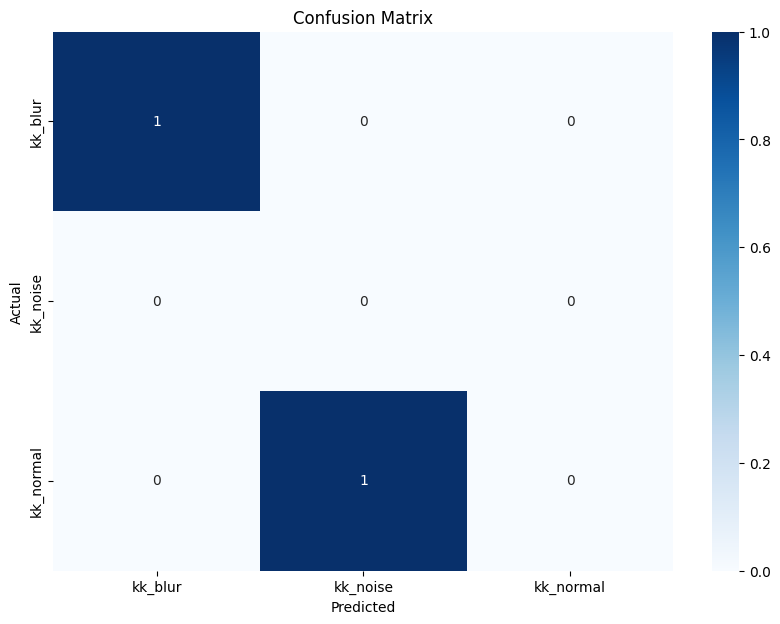

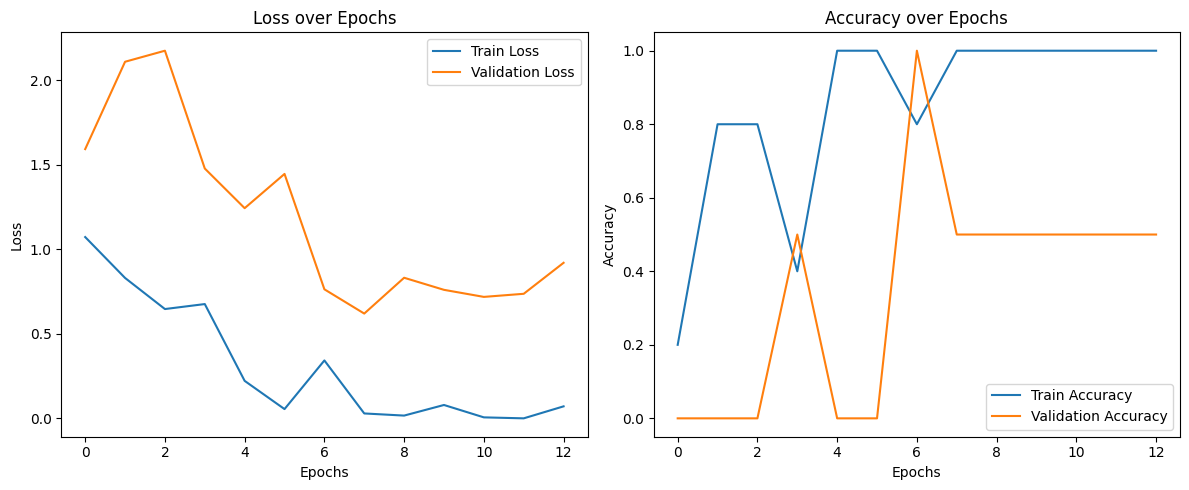

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
y_pred = np.argmax(model.predict(X_test), axis=1)

# Metrics
report = classification_report(y_test, y_pred, target_names=categories)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print(report)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Training history plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
